In [12]:
#Stochastic Gridworld Experiment


mutable struct GridWorld
    
    #################################
    #7x10 Fields   
    #------------------------------
    # 1  2  3  4  5  6  7  8  9  10
    # 11 12 13 14 15 16 17 18 19 20
    # 21 22 23 24 25 26 27 28 29 30
    # 31 32 33 34 35 36 37 38 39 40
    # 41 42 43 44 45 46 47 48 49 50
    # 51 52 53 54 55 56 57 58 59 60
    # 61 62 63 64 65 66 67 68 69 70
    #-------------------------------
    #  0  0  0  1  1  1  2  2  1  0
    #################################
    
    start::Int64
    goal::Int64
    position::Int64
    windvec::Array{Int64,1}
    stand_still::Bool
    
    function GridWorld(start = 31 , goal = 38, position = 31, windvec = [0,0,0,1,1,1,2,2,1,0],
        stand_still = false)
        new(start,goal,position,windvec,stand_still)
    end
    
end


function move(g::GridWorld,dir::Int64)
    
    # up = 1 , right = 2, down = 3, left = 4
    # rightup = 5, rightdown = 6, leftdown = 7, leftup = 8 (stand_still = 9)
    # Calculate resultant next state regardless of wind
    
    if dir == 1
        (g.position - 10 <= 0) ? tmp_pos =  g.position : tmp_pos = g.position - 10
    elseif dir == 2
        (g.position % 10 == 0) ? tmp_pos = g.position : tmp_pos = g.position + 1
    elseif dir == 3
        (g.position + 10 > 70) ? tmp_pos = g.position : tmp_pos = g.position + 10
    elseif dir == 4
        (g.position % 10 == 1) ? tmp_pos = g.position : tmp_pos = g.position -1
    elseif dir == 5
        ((g.position - 10 <=0) |(g.position % 10 == 0)) ? tmp_pos = g.position : tmp_pos = g.position - 9 
    elseif dir == 6
        ((g.position % 10 == 0) | (g.position + 10 > 70)) ? tmp_pos = g.position : tmp_pos = g.position + 11
    elseif dir == 7
        ((g.position + 10 > 70) | (g.position % 10 == 1)) ? tmp_pos = g.position : tmp_pos = g.position + 9
    elseif dir == 8
        ((g.position % 10 == 1) | (g.position - 10 <=0)) ? tmp_pos = g.position : tmp_pos = g.position - 11
    else 
        tmp_pos = g.position
    end
    g.position = tmp_pos
end

function action(g::GridWorld, act::Int64)
    if g.position%10 == 0
        vertical_pos = 10
    else
        vertical_pos = g.position%10
    end
    
    wind = g.windvec[vertical_pos]    #Check for wind at current position
    
    move(g,act)
    
    if wind == 2
        move(g,1)
        move(g,1)
    elseif wind == 1
        move(g,1)
    end
    
    if g.position == g.goal
        g.position = g.start   #reset environment
        return (0,true)
        
    else
        return (-1,false)
    end
    
end

function eps_greedy(Q::Array{Float64,2}, epsilon::Float64, S::Int64)
    randnr = rand()
    if randnr > epsilon
        A = argmax(Q[S,:])
    else
        A = rand(1:size(Q)[2])
    end
    return A
end

eps_greedy (generic function with 1 method)

In [13]:
function Sarsa(nits; α = 0.5, γ = 0.6, ϵ = 0.1, stand_still = false)
    #Sarsa (on-policy TD control) for estimating Q ≈ q*
    #Learn for nits iterations
    
    g = GridWorld()
    
    #For comparing learning performance:
    episodelength = zeros(nits)
    
    ###################################
    if stand_still
        Q = zeros(70,9)
    else
        Q = zeros(70,8)
    end

    for episode in 1:nits
    
        isDone = false
        S = g.start
        A = eps_greedy(Q,ϵ,S)

    
        while !isDone
            
            episodelength[episode] += 1
            
            (R,isDone) = action(g,A)
            S´ = g.position

            A´ = eps_greedy(Q,ϵ,S´)

            Q[S,A] += α*(R + γ* Q[S´,A´] - Q[S,A])
        
            S = S´
            A = A´
        end

    end
    
    return (Q,episodelength)
    
end

Sarsa (generic function with 1 method)

In [14]:
function run_episode(Q,ϵ,g)
   isDone = false
    states = []
    actions = []
    rewards = []
    
    while !isDone
        S = g.position
        A = eps_greedy(Q,ϵ,S)
        (R, isDone) = action(g,A)
        push!(states,S)
        push!(actions,A)
        push!(rewards,R)
    end
    return (states,actions,rewards)
end

run_episode (generic function with 1 method)

In [16]:
g = GridWorld()
Q = Sarsa(100000,stand_still = false);
run_episode()
#length(run_episode(Q,0.0,g)[1])

([-2.49335 -2.49159 … -2.49255 -2.49308; -2.49202 -2.49173 … -2.49161 -2.4936; … ; -1.62856 -1.69995 … -1.67727 -1.64992; -1.86428 -1.83728 … -1.87457 -1.72749], [1406.0, 298.0, 143.0, 203.0, 193.0, 264.0, 149.0, 83.0, 146.0, 55.0  …  7.0, 7.0, 7.0, 7.0, 9.0, 8.0, 7.0, 7.0, 7.0, 7.0])

![Optimal Trajectory](trajec.png)


Red: Optimal Trajectory when allowing King's Moves. Allowing the agent to stand still does not yield any improvement.

In [69]:
function Q_Learn(nits; α = 0.5, γ = 0.6, ϵ = 0.1, stand_still = false)
    #Q-learning (Off-policy TD control) for estimating π ≈ π*
    
    g = GridWorld()
    #For comparing learning performance:
    episodelength = zeros(nits)
    
    ###################################
    
    if stand_still
        Q = zeros(70,9)
    else
        Q = zeros(70,8)
    end

    for episode in 1:nits
    
        isDone = false
        S = g.start
    
        while !isDone
            
            episodelength[episode] += 1
            A = eps_greedy(Q,ϵ,S)
            (R,isDone) = action(g,A)
            S´ = g.position
            
            Q[S,A] += α*(R + γ* maximum(Q[S´,:]) - Q[S,A])
        
            S = S´
        end
        
    end
    
    return (Q,episodelength)
end


function Expected_Sarsa(nits; α = 0.5, γ = 0.6, ϵ = 0.1, stand_still = false)
    #Q-learning (Off-policy TD control) for estimating π ≈ π*
    if stand_still
        nacts = 9
    else
        nacts = 8
    end
    
    #For comparing learning performance:
    episodelength = zeros(nits)
    
    ###################################
    
    
    g = GridWorld()
    Q = zeros(70,nacts)

    for episode in 1:nits
    
        isDone = false
        S = g.start
    
        while !isDone
            episodelength[episode] += 1
            A = eps_greedy(Q,ϵ,S)
            (R,isDone) = action(g,A)
            S´ = g.position
            
            greedy_choice = argmax(Q[S',:])
            
            policy = [((i==greedy_choice) ? 1-ϵ+(ϵ/nacts) : ϵ/nacts) for i in 1:nacts]
            
            
            Q[S,A] += α*(R + γ*sum(policy.* Q[S´,:]) - Q[S,A])
            S = S´
        end
        
    end
    
    return (Q,episodelength)
end

Expected_Sarsa (generic function with 1 method)

In [80]:
(Q1,eplength1) = Sarsa(250,ϵ = 0.05)
(Q2, eplength2) = Q_Learn(250, ϵ = 0.05)
(Q3,eplength3) = Expected_Sarsa(250, ϵ = 0.05);

In [101]:
nits = 300
nruns = 500
eplength1 = zeros(nits)
eplength2 = zeros(nits)
eplength3 = zeros(nits)

for run in 1:nruns
    eplength1 += Sarsa(nits)[2]
    eplength2 += Q_Learn(nits)[2]
    eplength3 += Expected_Sarsa(nits)[2]
end

(eplength1, eplength2, eplength3) = (1/nruns .*eplength1, 1/nruns .*eplength2, 1/nruns .*eplength3);

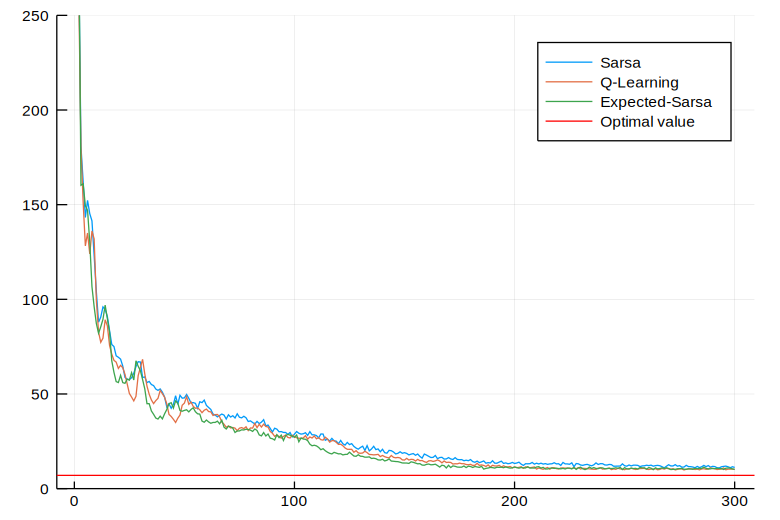

In [119]:
##Plotting Episodes vs Steps per Episode
using Plots

plot(1:length(eplength1),[eplength1,eplength2,eplength3], ylim = (0,250),dpi = 130,
            label = ["Sarsa","Q-Learning","Expected-Sarsa"])
hline!([7], color = "red", label = "Optimal value")

In [13]:
#TD VALUE ESTIMATION

V = zeros(70)

for episode in 1:1000
    isDone = false
    S = g.start
    while !isDone
        A = eps_greedy(Q,ϵ,S)
        (R,isDone) = action(g,A)
        S´ = g.position
        A´ = eps_greedy(Q,ϵ,S´)
        V[S] += α*(R + γ* V[S´] - V[S])
        S = S´
    end
    
end


In [28]:
arr = [1,2,3,3,4,1,5,1,1,2]

maximum(arr)

arr[arr .== max]



0-element Array{Int64,1}